In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import concurrent
from scipy.optimize import rosen

In [2]:
from pyBO import pyBO
from pyBO import Auto
from pyBO.model import GaussianProcess
from pyBO.covfunc import squaredExponential, matern52, matern32
from pyBO.util import proximal_ordered_init_sampler

In [3]:
# budget = 32
n_init = 8
ndim = 2
bounds = np.array(((-2,2),)*ndim)

evaluation_wait_time = 2

In [4]:
def np_str(x,precision=3):
    return np.array2string(x, precision=precision)

### cost func

In [5]:
def bilog_inv_rosen(x):
    y = -rosen(x)
    return np.sign(y)*np.log(1+np.abs(y))

In [6]:
def bilog_inv_rosen_vec(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = bilog_inv_rosen(x[i,:])
    return y

In [7]:
def delayed_bilog_inv_rosen(x):
    time.sleep(evaluation_wait_time)
    return bilog_inv_rosen(x)

# asynchronous BO

##### init 

In [8]:
x0 = np.random.rand(1,ndim)*(bounds[:,1]-bounds[:,0])+bounds[:,0]  # current set point
y0 = bilog_inv_rosen_vec(x0)

##### assuming decision parameter polarity change is costly

In [9]:
train_x = proximal_ordered_init_sampler(n_init,bounds=bounds,x0=x0,ramping_rate=np.ones(ndim),polarity_chage_time=10,method='sobol',seed=None)
train_y = bilog_inv_rosen_vec(train_x)
train_x = np.concatenate((x0,train_x),axis=0)
train_y = np.concatenate((y0,train_y),axis=0)

(-2.0, 2.0)

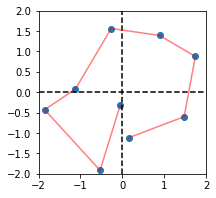

In [10]:
# check initial candidates are ordered to minimize ramping time including polarity change time
fig,ax=plt.subplots(figsize=(3,3))
ax.plot(train_x[:,0],train_x[:,1],alpha=0.5,c='r')
ax.scatter(train_x[:,0],train_x[:,1])
ax.hlines(0,bounds[0,0],bounds[0,1],ls='--',color='k')
ax.vlines(0,bounds[1,0],bounds[1,1],ls='--',color='k')
ax.set_xlim(bounds[0,0],bounds[0,1])
ax.set_ylim(bounds[1,0],bounds[1,1])

In [11]:
model = GaussianProcess(matern52())
bo = pyBO(
            model = model,
            x = train_x, 
            y = train_y,
            bounds = bounds,
#             acquisition_func = 'UpperConfidenceBound'  # = UCB
            acquisition_func = 'ExpectedImprovement'  # = EI
         )

[████████████████████████████████████████] 100%/100%



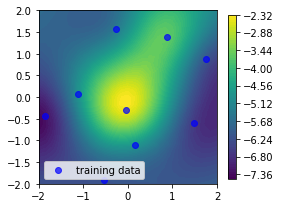

In [12]:
# plot initialized model with initial data. 
fig,ax = plt.subplots(figsize=(4,3))
# project maximum along the dimensions orthogonal to the porjected dimension
# projection dimensions are dim_xaxis=0,dim_yaxis=1 by default
# the goal of BO is maximization. 
bo.plot_model_2D_projection(project_maximum=True,fig=fig,ax=ax)
fig.tight_layout()

[████████████████████████████████████████] 100%/100%



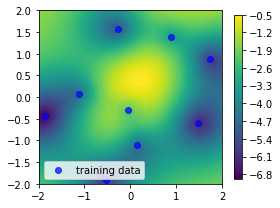

In [13]:
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(project_maximum=True,fig=fig,ax=ax)
fig.tight_layout()

In [14]:
##### remind bounds
bounds

array([[-2,  2],
       [-2,  2]])

###### test favor center

In [15]:
#default querry acquisition function is 'EI'
x1 = bo.query_candidates(bounds = bounds,
                         X_favor = np.zeros(ndim),
                         L_favor = 0.2,
                         C_favor = 100,
                         )
bo.remove_qeury_record()  # remove this test query record
x1  # resulting candidate is near the center

array([[-1.37785012e-05,  5.83919799e-05]])

###### test penalize center

In [16]:
x1 = bo.query_candidates(bounds = bounds,
                         X_penal = np.zeros(ndim),
                         L_penal = 1.0,
                         C_penal = 100)
bo.remove_qeury_record() 
x1 # resulting candidate is far from the center

array([[2., 2.]])

###### 1st query 

In [17]:
# w/o penalization  
# defult bounds is same as the most recent one
x1 = bo.query_candidates( X_current = train_x[-1:,:],  # this is used to impose polarity change penality
                          polarity_penalty = 0.5,
                          X_penal = Auto,  # this is used to penalize currently set point. L_penal, C_penal will be automatically selected based on data
                          X_favor = None
                         )

executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
y1_future = executor.submit(delayed_bilog_inv_rosen,x1.flatten())  # asynchronous parallel objective evaluation

[████████████████████████████████████████] 100%/100%



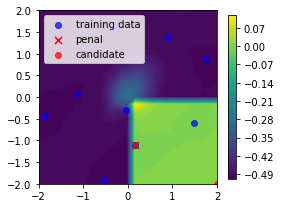

In [18]:
# check acuquisition functions
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(project_maximum=True,fig=fig,ax=ax)
fig.tight_layout()
ax.legend()

###### 2nd query while evaluating 1st candidate

In [19]:
x2 = bo.query_candidates(
                         x_candidate = x1, 
                         y_candidate_future = y1_future, # this is used to stop optimization of query when the objective evaulation is done
                         X_current = Auto,  # if x_candidate is not None, X_current = x_candidate
                         polarity_penalty = 0.5,
                         X_penal = Auto,  # this will penalize near the X_current. L_penal, C_penal will be automatically selected based on data
                         X_favor = None,
                        )

[████████████████████████████████████████] 100%/100%



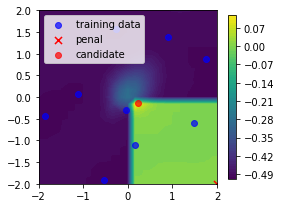

In [20]:
# check acuquisition functions
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(project_maximum=True,fig=fig,ax=ax)
fig.tight_layout()

###### get 1st candidate evaluated result and update model while evaluating 2nd candidate

In [21]:
y1 = [y1_future.result()]  # get the evaluated result of the 1st candidate that ran asynchronously
y2_future = executor.submit(delayed_bilog_inv_rosen,x2.flatten())  # asynchronous parallel objective evaluation for 2nd candidate
bo.update_model(x1=x1,y1=y1) # update model while evaluating the 2nd candidate

[████████████████████████████████████████] 100%/100%



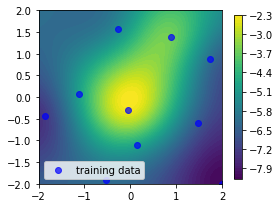

In [22]:
# plot updated model
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_model_2D_projection(project_maximum=True,fig=fig,ax=ax,grid_ponits_each_dim=64)
fig.tight_layout()

###### get 2nd candidate evaluated result and update model while evaluating 3rd candidate

In [23]:
# following steps in this cell is wrapped in bo.step
y2 = [y2_future.result()]                  # get the evaluated result of the 2nd candidate that ran asynchronously

x3 = bo.query_candidates(bounds=bounds,     
                         x_candidate = x2,
                         y_candidate_future = y2_future,
                         polarity_penalty = Auto,  # polarity_penalty is choosen by 10% of the current acquisition values on training data.
                         X_penal = Auto,  # this will penalize near the X_current as well as the training data points. L_penal, C_penal will be automatically selected based on data
                         X_favor = Auto,  # this will favor near the X_current (while penalizing same point but with larger length scale: L_favor > L_penal when both are automatically selected)
                        )

y3_future = executor.submit(delayed_bilog_inv_rosen,x3.flatten())  # asynchronous parallel objective evaluation for 3rd candidate

bo.update_model(x1=x2,y1=y2) # update model while evaluating the 3rd candidate

[████████████████████████████████████████] 100%/100%



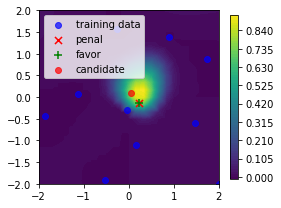

In [24]:
# check acuquisition functions
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(epoch=-2,project_maximum=True,fig=fig,ax=ax)
fig.tight_layout()

###### get 3rd candidate evaluated result and update model while evaluating 4th candidate using bo.step

In [25]:
x4,y4_future = bo.step(delayed_bilog_inv_rosen,x3,y3_future,
                      polarity_penalty = Auto,
                      X_penal = Auto, 
                      X_favor = Auto,
                      )

[████████████████████████████████████████] 100%/100%



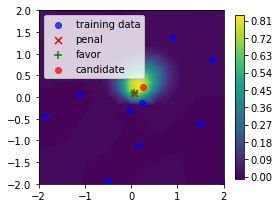

In [26]:
# check acuquisition functions
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(epoch=-2,project_maximum=True,fig=fig,ax=ax)
fig.tight_layout()

###### more looping using bo.step

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

!!!! not invertible adding constant diangonal noise.....
[████████████████████████████████████████] 100%/100%

!!!! not invertible adding constant diangonal noise.....
[████████████████████████████████████████] 100%/100%



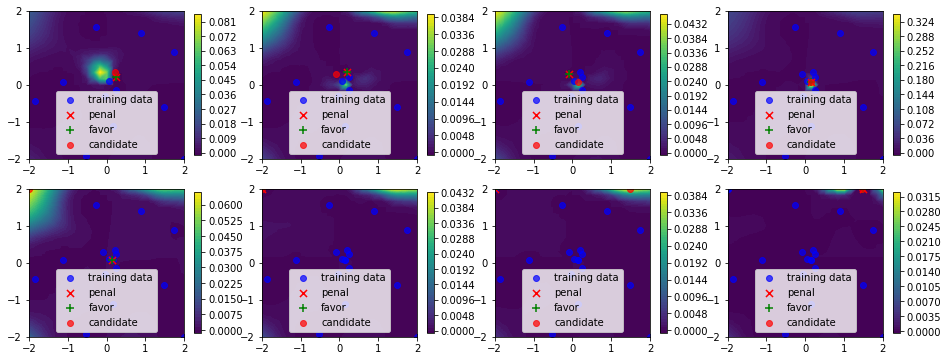

In [27]:
x = x4
y_future = y4_future
fig,ax = plt.subplots(2,4,figsize=(16,6))
for i in range(2):
    for j in range(4):
        x,y_future = bo.step(delayed_bilog_inv_rosen,x,y_future,
                            polarity_penalty = Auto,
                            X_penal = Auto,
                            X_favor = Auto,
                            )
        bo.plot_acquisition_2D_projection(epoch=-2, project_maximum=True,fig=fig,ax=ax[i,j])

In [28]:
for i in range(8):
    x,y_future = bo.step(delayed_bilog_inv_rosen,x,y_future,
                        polarity_penalty = 0.5,
                        X_penal = Auto,
                        X_favor = Auto,
                        )

!!!! not invertible adding constant diangonal noise.....
!!!! not invertible adding constant diangonal noise.....
!!!! not invertible adding constant diangonal noise.....
!!!! not invertible adding constant diangonal noise.....
!!!! not invertible adding constant diangonal noise.....
!!!! not invertible adding constant diangonal noise.....


In [29]:
# pyBO compuation time is more or less the objective evaluation time 
#   -- except the 1st query when there is no pending point 
#   -- and also when evaluation time is shoter than single optmization loop over acquisition function).
# pyBO stops query loop when objective evaulation is done.
for hist in bo.history:
    print(hist['model_fit_time']+np.sum(hist['query_time']) < evaluation_wait_time*1.05)

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


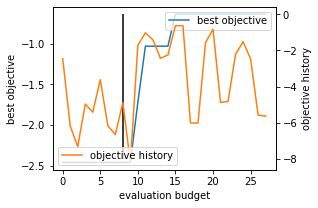

In [30]:
bo.plot_obj_history()
plt.vlines(n_init,-8,0,color='k')

In [31]:
x,y = bo.best_sofar()
x,y

(array([0.14969618, 0.06363681]), array([-0.6381577]))